# ACOL replication tensorflow

## Setup stuff

In [1]:
#imports and settings:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot
from sklearn.cluster import KMeans
jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
clustCount = 10
classCount = 2

## Network helper functions

In [3]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.5, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        

## Create placeholders (weights&biases)

In [4]:
#Init model weights & biases
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
x_image = tf.reshape(x, [-1,28,28,1])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

#conv_layer1
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

#conv_layer2
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

#fc layer 1
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

acol = initACOL(1024,clustCount,classCount)

#final fc layer
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

### Define network

In [5]:
dropout=0.3
#Define net
#conv 1
l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
l_pool1 = max_pool_2x2(l_conv1)

#conv 2
l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
l_pool2 = max_pool_2x2(l_conv2)

l_drop1 = tf.nn.dropout(l_pool2, tf.constant(dropout))

#fc 1
l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

l_fc1_drop = tf.nn.dropout(l_fc1, 0.3)

l_acol = connectACOL(l_fc1_drop,acol)

#Classification layer
stackedClusts = tf.stack(l_acol,1)
softmaxMat = matrix_softmax(stackedClusts)
smStacked = tf.reduce_max(softmaxMat,2)

y_conv = smStacked

## Helperfunctions for loss

In [6]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)#0.000001)

### Calculate loss

In [7]:
#calculate losses
#affinity
bZ = zBar(softmaxMat)
bU = bigU(bZ)
coact = selectNonDiag(bU)
affinity = specialNormalise(bU)

#balance
bV=bigV(bZ)
balance = specialNormalise(bV)

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

frob = frobNorm(softmaxMat)

loss = c0*cross_entropy + c1*affinity + c2*tf.subtract(tf.constant(1.0),balance) + c3(affinity)*coact + c4*frob

## Train network

In [8]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [9]:
y = {0:[0,1], 1:[1,0]}

totalSteps = 50000
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [10]:
for i in range(totalSteps):
    trainbatch = mnist.train.next_batch(batchSize)
    trainbatch = (trainbatch[0],np.array([y[np.argmax(trainbatch[1][j])>4] for j in range(len(trainbatch[1]))]))
    valbatch = mnist.validation.next_batch(batchSize)
    valbatch = (valbatch[0],np.array([y[np.argmax(valbatch[1][j])>4] for j in range(len(valbatch[1]))]))
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1]})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1]})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        print("cross_entropy: %g, affinity: %g, balance: %g, coact: %g, frob: %g"%(cc0*entr,cc1*hist['affinity'][-1],cc2*(1-hist['balance'][-1]),cc3*hist['coactivity'][-1],cc4*frb))
    feed_dict = {x: trainbatch[0], y_: trainbatch[1]}
    _ = sess.run([train_step],feed_dict=feed_dict)

step 0/50000 
 Train: accuracy: 0.523438, loss: 6.923 
 Validation: accuracy: 0.46875 loss: 7.27374
cross_entropy: 6.69285, affinity: 0.00460752, balance: 0.413898, coact: 0.00298293, frob: 1.08353e-05
step 100/50000 
 Train: accuracy: 0.53125, loss: 5.97902 
 Validation: accuracy: 0.539062 loss: 5.85923
cross_entropy: 5.45184, affinity: 0.00517989, balance: 0.325469, coact: 0.00363253, frob: 1.06531e-05
step 200/50000 
 Train: accuracy: 0.546875, loss: 5.76817 
 Validation: accuracy: 0.546875 loss: 5.97073
cross_entropy: 5.43818, affinity: 0.00540032, balance: 0.268848, coact: 0.00336105, frob: 1.07604e-05
step 300/50000 
 Train: accuracy: 0.492188, loss: 5.35987 
 Validation: accuracy: 0.53125 loss: 4.98529
cross_entropy: 4.07681, affinity: 0.00612328, balance: 0.234285, coact: 0.00447334, frob: 1.05701e-05
step 400/50000 
 Train: accuracy: 0.492188, loss: 4.81517 
 Validation: accuracy: 0.507812 loss: 3.97585
cross_entropy: 4.00721, affinity: 0.00529653, balance: 0.333502, coact: 0.

## Testing & visualising

In [11]:
testSize = 1000
testbatch = mnist.test.next_batch(testSize)
testbatch = (testbatch[0],np.array([y[np.argmax(testbatch[1][j])>4] for j in range(len(testbatch[1]))]))

test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1]})
print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))

Test: accuracy: 0.964, loss: 0.327267


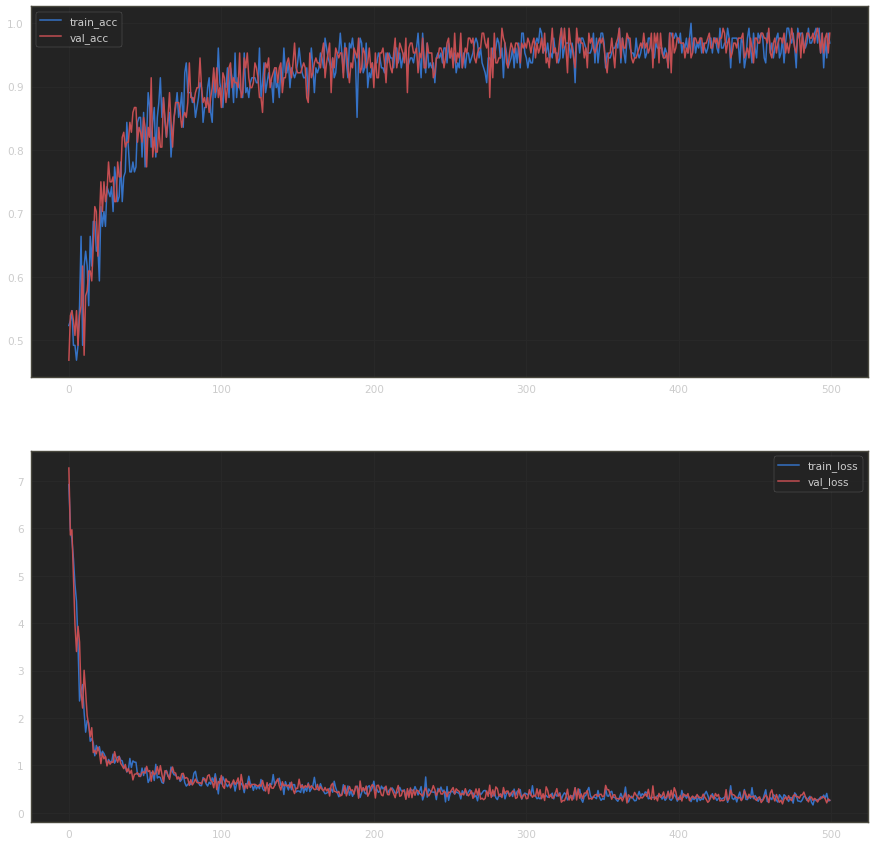

In [12]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

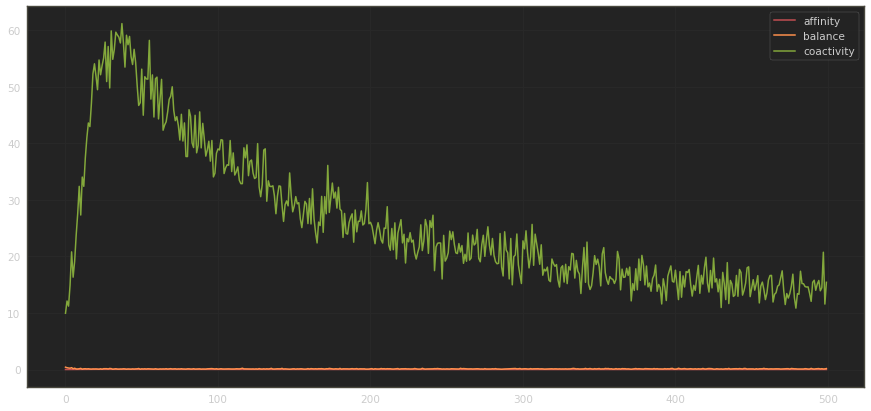

In [13]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [14]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(10)

In [15]:
#sess.run(tf.global_variables_initializer())
for i in range(1000):
    tb = mnist.test.next_batch(1)
    digitCount[np.argmax(tb[1])]+=1
    testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])>4] for j in range(len(tb[1]))]))
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1]})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1]})
    digitTrace[np.argmax(ypred),:] += testbatch[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [16]:
print digitCount
print digitTraceCount

[  90.  108.  103.  100.  107.   92.   91.  106.  103.  100.]
[ 25.  57.  34.  35.  64.  42.  45.  61.  48.  75.  66.  68.  43.  84.  70.
  25.  24.  52.  55.  27.]


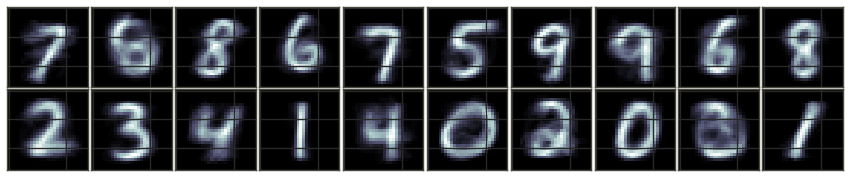

In [17]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [19]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

## Clustering score

In [21]:
tb = mnist.test.next_batch(1000)
testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])>4] for j in range(len(tb[1]))]))
testFeed = {x: testbatch[0], y_: testbatch[1]}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((1000,clustCount*classCount))
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(tb[1][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(tb[1],1).astype('int32'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print 'Clustering Accuracy: %g'%(accuracy)


Clustering Accuracy: 0.804


## Compare it to k-means

In [22]:
kmeans = KMeans(n_clusters=clustCount)
km_ypred = kmeans.fit_transform(l_fc1.eval(testFeed))
km_ypred = np.argmax(km_ypred,1)
km_ylookup = [np.argmax(np.sum(tb[1][km_ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
km_yconverted = [km_ylookup[i] for i in km_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb[1],1).astype('int32'))
km_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print 'ACOL Accuracy: %g'%(accuracy)
print 'KMeans Accuracy: %g'%(km_accuracy)

ACOL Accuracy: 0.804
KMeans Accuracy: 0.374
